In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [60]:
'''Funktionen zur Aufbereitung der Daten
'''

def load_data():
    col_names = [
                 'timestamp'
                ,'street_shoe_size'
                ,'fav_sneaker_model'
                ,'foot_len'
                ,'foot_width'
                ,'foot_type'
                ,'foot_deform'
                ,'shoe_brand'
                ,'shoe_model'
                ,'shoe_model_manual'
                ,'climb_shoe_size'
                ,'shoe_age'
                ,'favourite'
                ,'vorspann'
                ,'downturn'
                ,'asymetry'
                ,'closure_type'
                ,'climb_style'
                ,'terrain'
                ,'rate_fit'
                ,'rate_comfort'
                ,'rate_stiffness'
                ,'use_frequency'
                ,'climbed_grade'
                ,'overall_rating'
                ,'gender'
                ,'height'
                ,'weight'
                ,'age'
                ,'climbing_exp'
    ]
    
    data = pd.read_csv("./data/climb_shoe_survey.csv", header=0, names=col_names)
    data.sort_values(by='timestamp', inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

def get_brand_per_foottype(df_survey):
    '''
    Ermittle die meist genutzte Schuhmarke pro Fußtyp
    
    :param df: DataFrame df_survey
    
    :return: Dictionary Marken sortiert nach Anzahl
    '''
    foot_types = df_survey['foot_type'].unique()
    brand_per_foottype = pd.DataFrame(columns=['foot_type', 'brand', 'count'])

    for t in foot_types:
        new_row = {'foot_type' : t, 'brand' : df_survey['shoe_brand'][df_survey['foot_type'] == t].value_counts().keys()[0], 'count' : df_survey['shoe_brand'][df_survey['foot_type'] == t].value_counts()[0]}
        brand_per_foottype = brand_per_foottype.append(new_row, ignore_index=True)

    sorted_brands = brand_per_foottype.sort_values(by='count', ascending=False)
    
    return sorted_brands

def resolve_invalid_footdeforms(df_survey): # Resolve any observation with "no deform", but typed in a deform...
    '''
    Bereinige Angaben zur Fehlstellung. Alle Beobachtungen, die sowohl Nein als auch eine weitere Angabe gemacht haben.
    
    :param df: DataFrame df_survey
    
    :return: DataFrame df
    '''

    for i in df_survey[df_survey['foot_deform'] == 'Nein, Spreizfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Spreizfuß'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, Knickfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Knickfuß'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, Senkfuß, Spreizfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Senkfuß, Spreizfuß'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, Hallux Valgus, Senkfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Hallux Valgus, Senkfuß'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, Hallux Valgus'].index:
        df_survey.loc[i, 'foot_deform'] = 'Hallux Valgus'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, Senkfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Senkfuß'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, Senkfuß, Spreizfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Senkfuß, Spreizfuß'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, Plattfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Plattfuß'
    for i in df_survey[df_survey['foot_deform'] == 'Nein, abgeflachtes Quergewölbe, aber noch kein Spreizfuß'].index:
        df_survey.loc[i, 'foot_deform'] = 'Nein'
            
     
    return df_survey

def translate_values(df_survey, search_col, search_str, replace_str):
    '''
    Transformation und Bereinigung von Text. Ersetzt einen String-Wert gegen einen anderen.
    Zusätzlich wird der Wert kleingeschrieben zurückgegeben.
    
    :param df: DataFrame df_survey
    :param search_col: String relevante Spalte
    :param search_str: String Such-String
    :param replace_str: String Ersatz-String
    
    :return: DataFrame df
    '''
    df = df_survey[search_col].str.replace(search_str, replace_str).apply(lambda x: x.lower())
    return df


def resolve_invalid_foottype(df_survey, valid_foottype, false_foottype):
    '''
    Bereinige ungültige Fußtypen, z.B. Freitextangaben
    
    :param df: DataFrame df_survey
    :param col: String Spalte, die umgewandelt werden soll
    
    :return: DataFrame df_survey
    '''
    df = df_survey.apply(
        lambda row: valid_foottype
            if row.foot_type == false_foottype
          else row.foot_type, axis=1)
    return df


def generate_dummies(df_survey, col):
    '''
    Erstelle Dummy-Variablen für Spalten mit Komma-getrennten Listen als Ausprägungen
    
    :param df: DataFrame df_survey
    :param col: String Spalte, die umgewandelt werden soll
    
    :return: DataFrame df_survey
    '''
    df_survey = pd.concat([df_survey.drop(col, 1), df_survey[col].str.get_dummies(sep=", ")], 1)
    
    return df_survey

def count_deforms(df_survey): 
    '''
    Zähle pro Fehlstellung alle Vorkommnisse
    
    :param df: DataFrame df_survey
    :return: Dictionary mit sortierten Anzahlen pro Fehlstellung
    '''
    deformations = ['hallux', 'senkfuß','spreizfuß','plattfuß', 'hohlfuß','knickfuß']
    stats = {}

    for deform in deformations:
        stats.update({deform : df_survey[deform.lower().split()[0]].value_counts()[1]})
    print(stats) 
    stats_sorted = dict(sorted(stats.items(),key= lambda x:x[1]))
    
    return stats_sorted


def resolve_shoemodels(df_survey, models):
    '''
    Übernehme alle manuell eingetragenen Schuhmodelle
    
    :param df: DataFrame df_survey
    :param models: Dictionary mit Index und Schuhmodell
    
    :return: DataFrame df_survey
    '''
    for i in models:
        df_survey.loc[i,'shoe_model'] = models[i]
    return df_survey

In [61]:
# Daten laden
df_survey = load_data()

In [62]:
'''
PREPROCESSING
Daten vorbereiten
'''

# Ungültige Beobachtungen löschen
df_survey.drop(index=83, inplace=True, axis=0)        
df_survey.reset_index(drop=True, inplace=True)


# Daten transformieren:  - Ausprägungen für Fehlstellungen bereinigen, 
#                          wenn 'Nein' und trotzdem weitere Fehlstellungen aus gewählt wurden
#                        - Ausprägungen umbenennen


df_survey              = resolve_invalid_footdeforms(df_survey[:])
df_survey['foot_type'] = resolve_invalid_foottype(df_survey[:], 'Ägyptischer Fußtyp', 'Mix aus Römisch und Ägyptisch')
df_survey['deform']    = translate_values(df_survey[:], 'foot_deform', ' Valgus', '')
df_survey['foottype']  = translate_values(df_survey[:], 'foot_type', ' Fußtyp', '')

'''
Sonstige genannte Schuhmodelle übernehmen
'Sonstige' Schuhmodelle imputieren
'''
# Dictionary mit bekanntem Index und Schuhmodell. Dieser wird aufbereitet im Dictonary gespeichert
models = {11  : 'Red Chili - AMP',
          16  : 'Five Ten - DIAMOND',
          44  : 'Boreal - SATORI',
          58  : 'Evolv - SHAMAN 2',
          59  : 'Evolv - SHAMAN 2',
          61  : 'Evolv - SHAMAN 2',
          62  : 'Evolv - SHAMAN 2',
          85 :  'La Sportiva - MILLET EASY UP'}

df_survey = resolve_shoemodels(df_survey[:], models)

# Ermittle das häufigste Schuhmodell einer Marke und ersetze 'Sonstige'
most_common_models = {}
    
for i in df_survey.groupby(['shoe_brand', 'shoe_model'])['shoe_model'].count().sort_values().groupby(level=0).tail(1).index:
    most_common_models.update({i[0]:i[1]})
for i in df_survey['shoe_brand'][df_survey['shoe_model'] == 'Sonstige'].index:
    df_survey.at[i,'shoe_model'] = most_common_models[df_survey['shoe_brand'].iloc[i]]

df_survey.at[18,'shoe_model'] = df_survey.at[18,'shoe_brand']

# One hot encoding von Spalten mit komma-separierten Ausprägungslisten
df_survey = generate_dummies(df_survey[:], 'deform')
df_survey = generate_dummies(df_survey[:], 'climb_style')
df_survey = generate_dummies(df_survey[:], 'terrain')
df_survey = generate_dummies(df_survey[:], 'foottype')
df_survey = pd.get_dummies(data=df_survey, columns=['gender'],drop_first=True)

'''
Ausreißer bereinigen
'''
# Fußlänge unter 20
mask = df_survey['foot_len'] < 20
df_survey.loc[mask, 'foot_len'] = round(df_survey['foot_len'].mean(),2)


df_survey.head(1)

<ipython-input-60-d86d331ef299>:134: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_survey = pd.concat([df_survey.drop(col, 1), df_survey[col].str.get_dummies(sep=", ")], 1)
<ipython-input-60-d86d331ef299>:134: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df_survey = pd.concat([df_survey.drop(col, 1), df_survey[col].str.get_dummies(sep=", ")], 1)


,timestamp,street_shoe_size,fav_sneaker_model,foot_len,foot_width,foot_type,foot_deform,shoe_brand,shoe_model,shoe_model_manual,...,Bouldern,Mehrseillängen,Sportklettern,Beides,Halle,Outdoor,griechischer,römischer,ägyptischer,gender_Weiblich
0,01.03.2021 08:02:16,42.5,NaN,25.7,10.6,Ägyptischer Fußtyp,Nein,Scarpa,Scarpa - VAPOR V,NaN,...,0,0,1,0,1,0,0,0,1,0


In [63]:
'''
Erzeugung Dataframe mit aufbereiteten Daten für die Zuführung ins Modell-Training. 
'''
#Hier wird die Zielvariable shoe_model bereits entfernt!
df_prep = df_survey.drop(['timestamp','foot_deform','foot_type', 'fav_sneaker_model', 'shoe_brand', 'shoe_model',
       'shoe_model_manual', 'climb_shoe_size', 'shoe_age', 'favourite',
       'vorspann', 'downturn', 'asymetry', 'closure_type','rate_fit', 'rate_comfort', 'rate_stiffness',
       'use_frequency', 'climbed_grade', 'overall_rating', 'Beides', 'nein', 'ägyptischer'], axis=1)
df_prep.head(1)

,street_shoe_size,foot_len,foot_width,height,weight,age,climbing_exp,fersenbein,hallux,hohlfuß,...,senkfuß,spreizfuß,Bouldern,Mehrseillängen,Sportklettern,Halle,Outdoor,griechischer,römischer,gender_Weiblich
0,42.5,25.7,10.6,175,71.0,55,20.0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [64]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   street_shoe_size  186 non-null    float64
 1   foot_len          186 non-null    float64
 2   foot_width        186 non-null    float64
 3   height            186 non-null    int64  
 4   weight            186 non-null    float64
 5   age               186 non-null    int64  
 6   climbing_exp      186 non-null    float64
 7   fersenbein        186 non-null    int64  
 8   hallux            186 non-null    int64  
 9   hohlfuß           186 non-null    int64  
 10  knickfuß          186 non-null    int64  
 11  plattfuß          186 non-null    int64  
 12  senkfuß           186 non-null    int64  
 13  spreizfuß         186 non-null    int64  
 14  Bouldern          186 non-null    int64  
 15  Mehrseillängen    186 non-null    int64  
 16  Sportklettern     186 non-null    int64  
 1

In [65]:
df_prep.shape

(186, 22)

# Dummy-Variablenfalle

Nach Abschluss der Datenaufbereitung enthält der Datensatz 22 ausschließlich numerische Merkmale. Merkmale mit kategorialen Werten wurden durch Dummy-Variablen mit binärer Ausprägung ersetzt mittels One-Hot Codierung. Hierbei ist insbesondere die Beseitigung von so entstandenen Referenz-Variablen zu beachten. Ein Beispiel ist das Geschlecht. Durch die Transformation in Dummy-Variablen entsehen zwei Spalten: Geschlecht_Männlich mit der Ausprägung 0 oder 1, sowie eine Spalte Geschlecht_Weiblich mit dem selben Wertebereich. Ist eine Beobachtung männlich, besitzt sie in der Spalte Geschlecht_Männlich den Wert 1. Geschlecht_Weiblich kann in diesem Fall nur noch den Wert 0 annehmen. Die Beziehung zwischen den beiden Variablen wird Kolinearität genannt. Infolgedessen lässt sich die Information über das Geschlecht anhand einer einzigen Variable ableiten und wäre redundant, wenn nicht eine der beiden Variablen entfernt werden würde, was zu einer Verfälschung der Ergebnisse im Modelltraining führen würde. Das gleiche Prinzip lässt sich auf alle kategorialen Merkmale anwenden, die in einer perfekten Kolinearität stehen.
https://www.learndatasci.com/glossary/dummy-variable-trap/


# Fluch der Dimensionalität

Der aufbereitete Datensatz besteht aus 181 Beobachtungen mit 22 Merkmalen. Jedes Merkmal kann als Dimension in einem Koordinatensystem betrachtet werden, in dem jede Beobachtung einen Datenpunkt auf jeweils einer X- und Y-Achse pro Dimension besitzt. Ließen sich grafische Darstellung im 22-dimensionalem Raum grafisch Darstellen, wären sehr viele weit zerstreute Datenpunkte zu sehen, aus denen keinerlei Muster ableitbar wären. Die verschwindend geringe Datenmenge in Kombination mit der Dimensionszahl ist ein großes Problem, insbesondere bei der Nutzung von Distanzbasierten Algorithmen wie KNN. Der Fluch der Dimensionalität beschreibt genau dieses Problem. Das Phänomen mit einer Vielzahl an Merkmalen konfrontiert zu sein und nicht genügend Beobachtungen vorliegen zu haben, um Datemmuster ausreichend beschreiben und zutreffende Vorhersagen machen zu können.  Die in der Praxis angewandte Maßnahme in so einem Fall ist die Dimensionsreduktion. Hier wird bewusst die Anzahl der Dimensionen reduziert bei gleichzeitig geringem Informationsverlust, um die Komplexität des Modells deutlich zu veringern. Ein mögliches Verfahren hierfür ist die Hauptkomponentenanalyse.

In [279]:
''' Vorbereitung Modell-Training

1. X und y werden initialisiert
2. Daten werden skaliert
3. Dimensionen werden mittels PCA reduziert
4. Daten werden in Trainings- und Testdaten gesplittet

'''
X = df_prep
y= df_survey['shoe_model'].values
test_size = 0.33
folds = 5
scoring = "accuracy"

# Daten skalieren
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

# Dimensionsreduktion mittels Hauptkomponentenanalyse (PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=0.60, whiten=True)
pca_features = pca.fit_transform(scaled_features)

print("Ursprüngliche Anzahl an Merkmalen:", scaled_features.shape[1])
print("Reduzierte Anzahl an Merkmalen:", pca_features.shape[1])


# Datensatz in Training- und Testdaten splitten
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pca_features, y, test_size=test_size)

Ursprüngliche Anzahl an Merkmalen: 22
Reduzierte Anzahl an Merkmalen: 7


In [280]:
pca_features.shape

(186, 7)

In [281]:
# Plot the explained variance on a bar chart
# Set x and y axis
x_ax=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']
y_ax=pca.explained_variance_ratio_.round(3)*100

# Create a plot
plt.figure(figsize=(10,8), dpi=300)
plt.bar(x=x_ax, height=y_ax, color='black')

# Annotate chart by adding values on top of the bars
for i in range(len(x_ax)):
    plt.text(i,y_ax[i]+0.2,str(y_ax[i].round(3))+'%', ha = 'center')

# Set title for chart and axis        
plt.title(label='PCA Variance Explained', loc='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')

# plt.show()

Text(0, 0.5, 'Explained Variance (%)')

Mithilfe des PCA Verfahrens wurde der Datensatz auf 7 Dimensionen reduziert. Übrig blieb allerdings nur noch eine Varianz von 60%, demnach sind 40% der Informationen verloren gegangen. Besonders auffälig ist, dass die Hauptkomponente PC1 24,6% davon ausmacht, während die restlichen Hauptkomponenten 9% und darunt

In [282]:
X_train.shape

(124, 7)

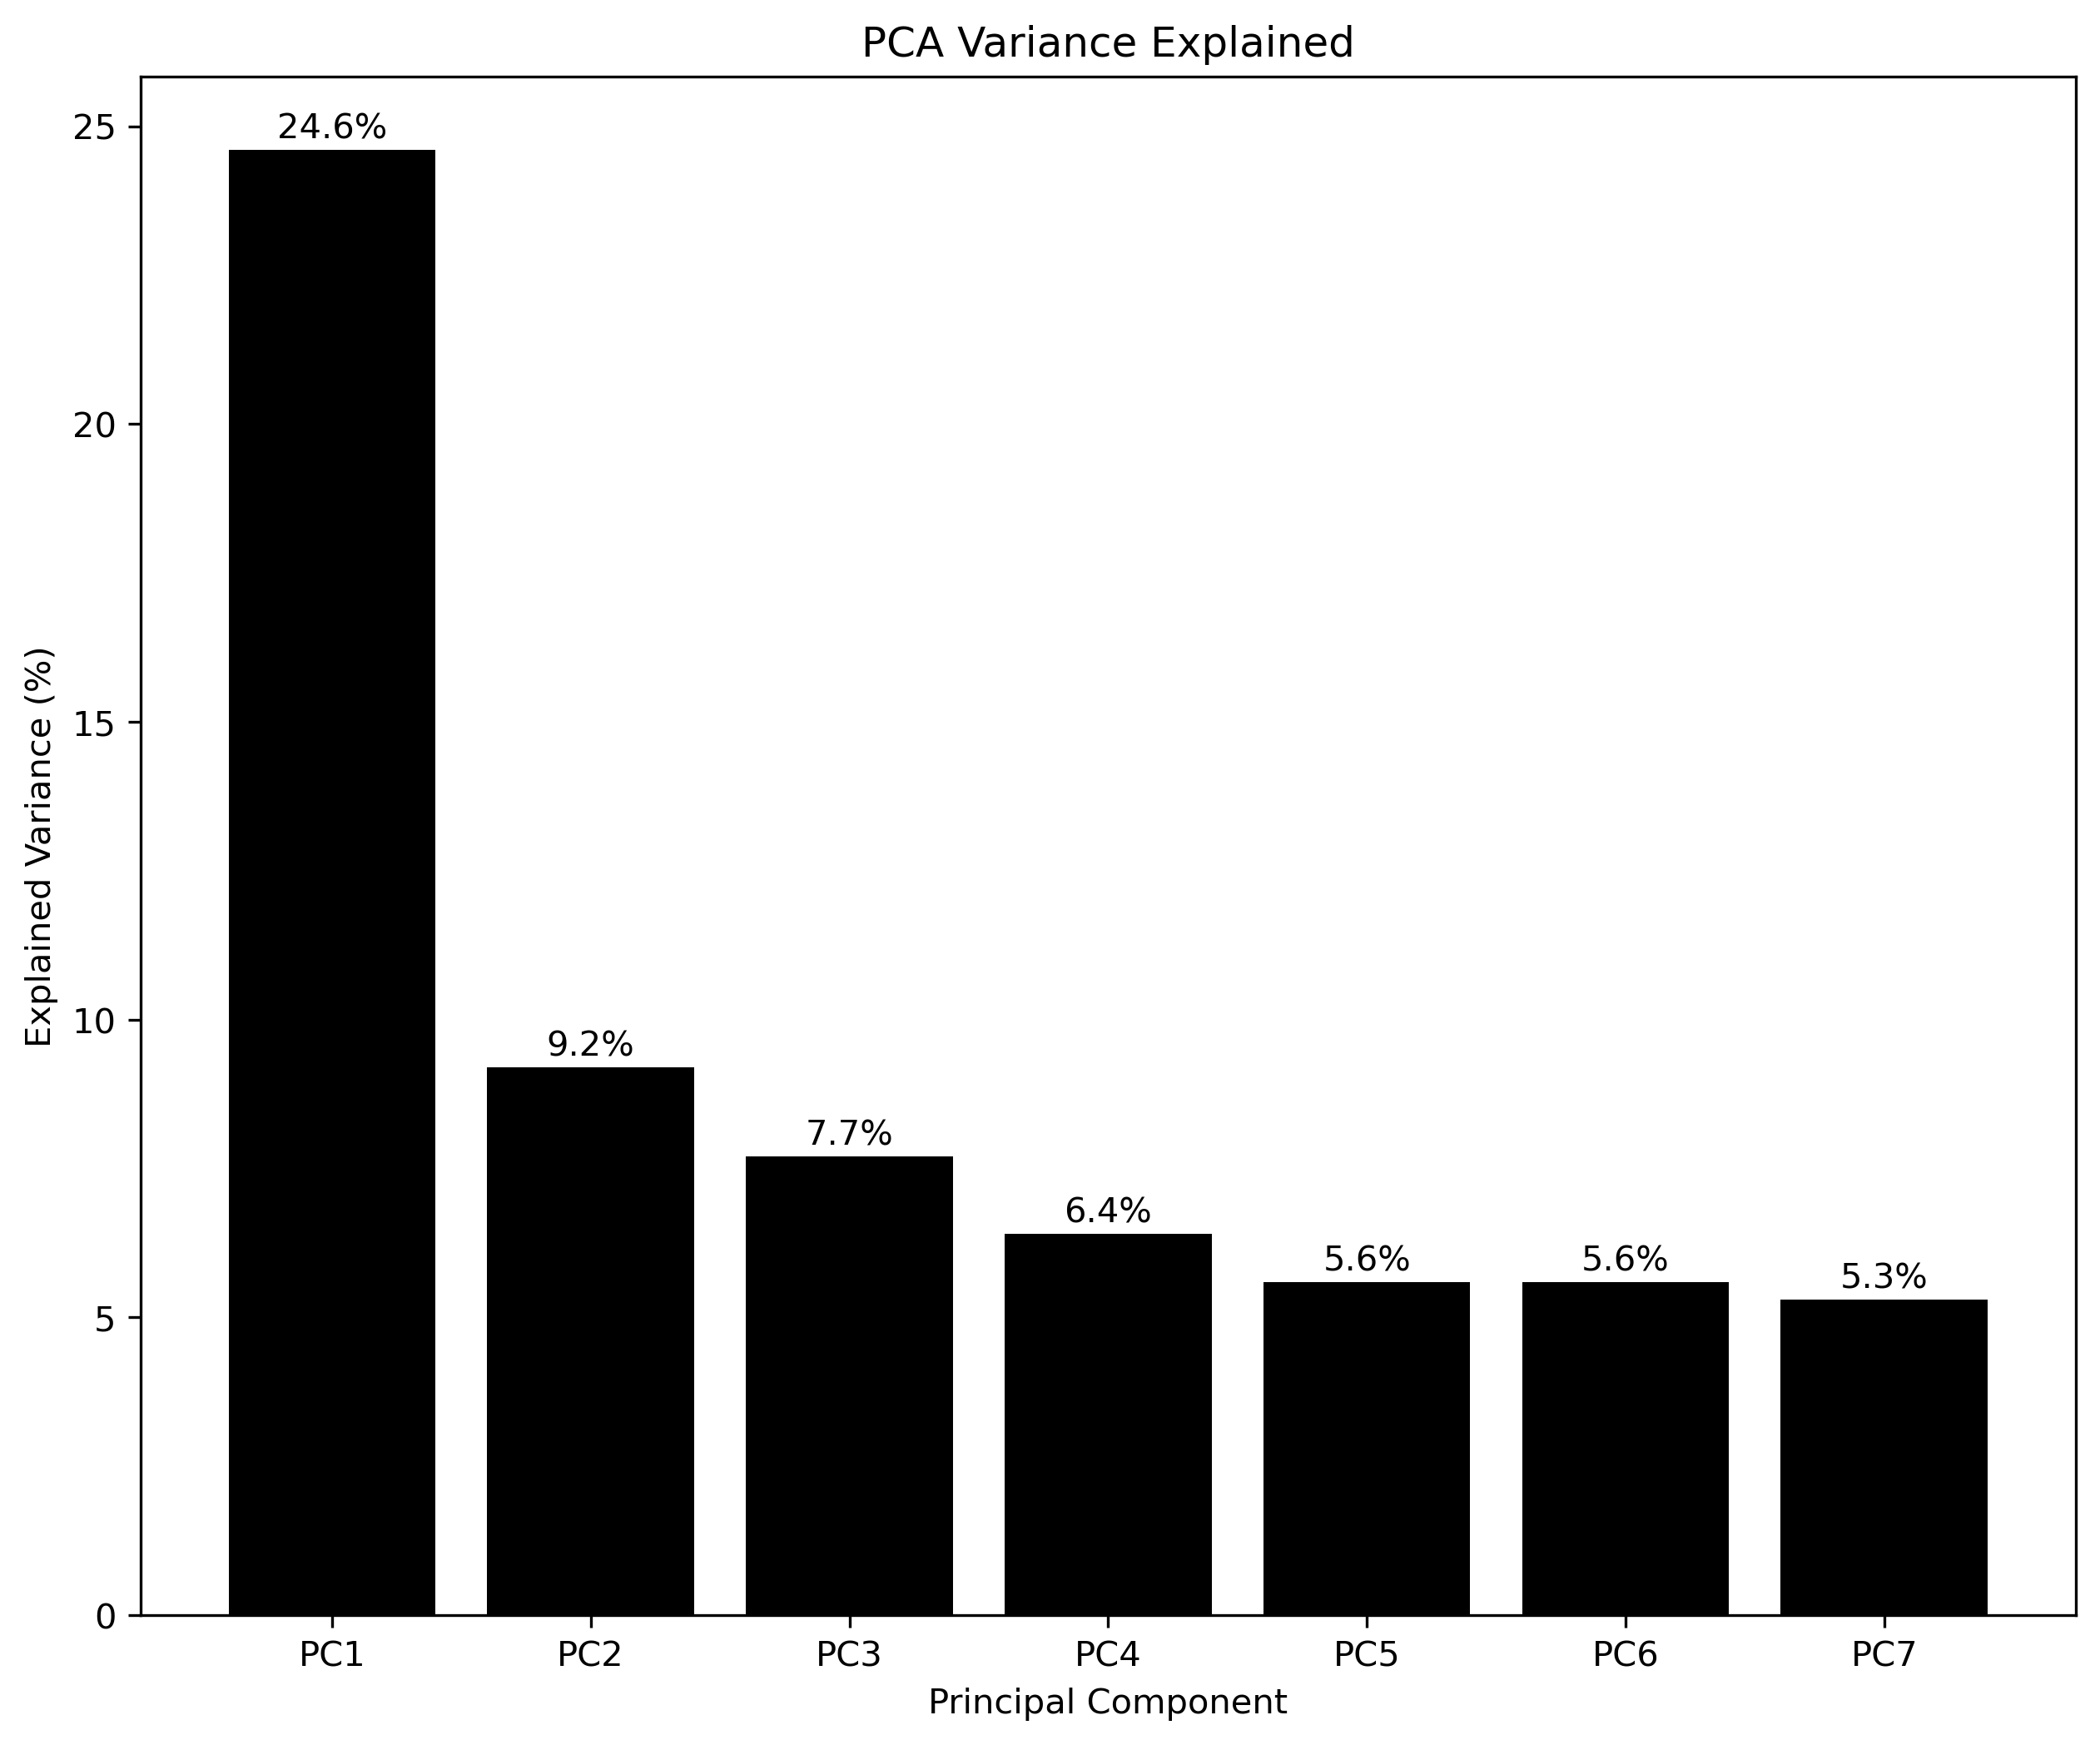

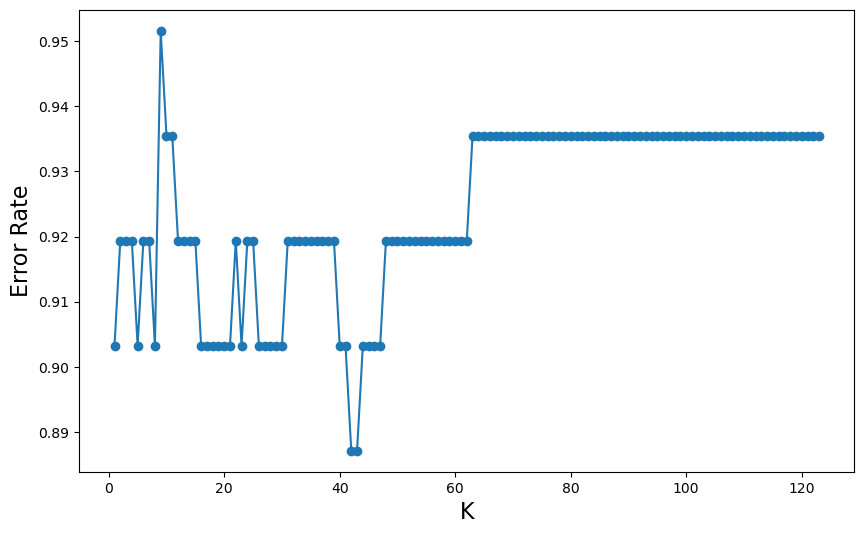

In [283]:
''' KNN-Klassifikator: K ermitteln mittels Elbow-Methode
'''
from sklearn.neighbors import KNeighborsClassifier

error_rate = []

k_max = k_max = X_train.shape[0]

for i in range(1,k_max):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(10,6))

plt.plot(range(1,k_max), error_rate, marker='o')
plt.ylabel('Error Rate', fontsize=16)
plt.xlabel('K', fontsize=16)
plt.show()

In [284]:
''' KNN-Klassifikator: Training
'''
from sklearn.neighbors import KNeighborsClassifier

# Initialisiere K-Nearest Neighbor Classifier Objekt
knn = KNeighborsClassifier(n_neighbors=39, n_jobs=-1)

# Trainiere das Modell mit den skalierten X-Werten und füge die Trainigswerte für y hinzu
knn.fit(X_train,y_train)

# Modellbewertung mittels K-Fold Crossvalidation
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=folds, shuffle=True, random_state=1)
cv_results = cross_val_score(knn, X_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)

print(f"{scoring}: {cv_results.mean()}")

accuracy: 0.08133333333333333


In [285]:
''' KNN-Klassifikator: Hyperparameter ermitteln mittels GridSearch
    ACHTUNG: TEUER!!!!!!
'''
#from sklearn.pipeline import Pipeline, FeatureUnion
#from sklearn.model_selection import GridSearchCV

#knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
#k = 95
#pipe = Pipeline([("knn", knn)])


#search_space = [{"knn__n_neighbors": range(1, k),
#                 "knn__leaf_size" : range(10,100, 10),
#                 "knn__metric" : ["minkowski", "manhattan", "euclidean", "chebyshev"], 
#                 "knn__algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
#                 "knn__weights" : ['uniform', 'distance']}]

#gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=0).fit(X_train, y_train)

#gridsearch.best_estimator_.get_params()

' KNN-Klassifikator: Hyperparameter ermitteln mittels GridSearch\n    ACHTUNG: TEUER!!!!!!\n'

In [286]:
''' KNN-Klassifikator: Training mit Hyperparameter
'''
from sklearn.neighbors import KNeighborsClassifier

# Initialisiere K-Nearest Neighbor Classifier Objekt
knn = KNeighborsClassifier(leaf_size=10, metric='chebyshev', n_jobs=-1,
                      n_neighbors=29, weights='distance') #gridsearch.best_estimator_.get_params()["knn"]

# Trainiere das Modell mit den skalierten X-Werten und füge die Trainigswerte für y hinzu
knn.fit(X_train,y_train)

# Modellbewertung mittels K-Fold Crossvalidation
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=folds, shuffle=True, random_state=1)
cv_results = cross_val_score(knn, X_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)

print(f"{scoring}: {cv_results.mean()}")

accuracy: 0.097


In [287]:
''' Entscheidungsbaum: Entscheidungsbaum
'''
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier(criterion='entropy', random_state=0, class_weight="balanced")

tree_model = decisiontree.fit(X_train, y_train)

from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=folds ,shuffle=True, random_state=1)

cv_results = cross_val_score(decisiontree, X_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)
print(f"{scoring}: {cv_results.mean()}")


accuracy: 0.056666666666666664


In [288]:
''' Entscheidungsbaum: Random Forest
'''
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(criterion='entropy',random_state=0, n_jobs=-1, class_weight="balanced")

forest_model = randomforest.fit(X_train, y_train)


# Modellbewertung
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=folds, shuffle=True, random_state=1)
cv_results = cross_val_score(randomforest, X_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)
print(f"{scoring}: {cv_results.mean()}")

accuracy: 0.08866666666666666


In [289]:
''' Entscheidungsbaum: Boosted
'''
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(random_state=0, n_estimators = 1000, learning_rate=0.3)

ada_model = adaboost.fit(X_train, y_train)

from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline



kf = KFold(n_splits=folds, shuffle=True, random_state=1)
cv_results = cross_val_score(ada_model, X_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)
print(f"{scoring}: {cv_results.mean()}")

accuracy: 0.07266666666666667


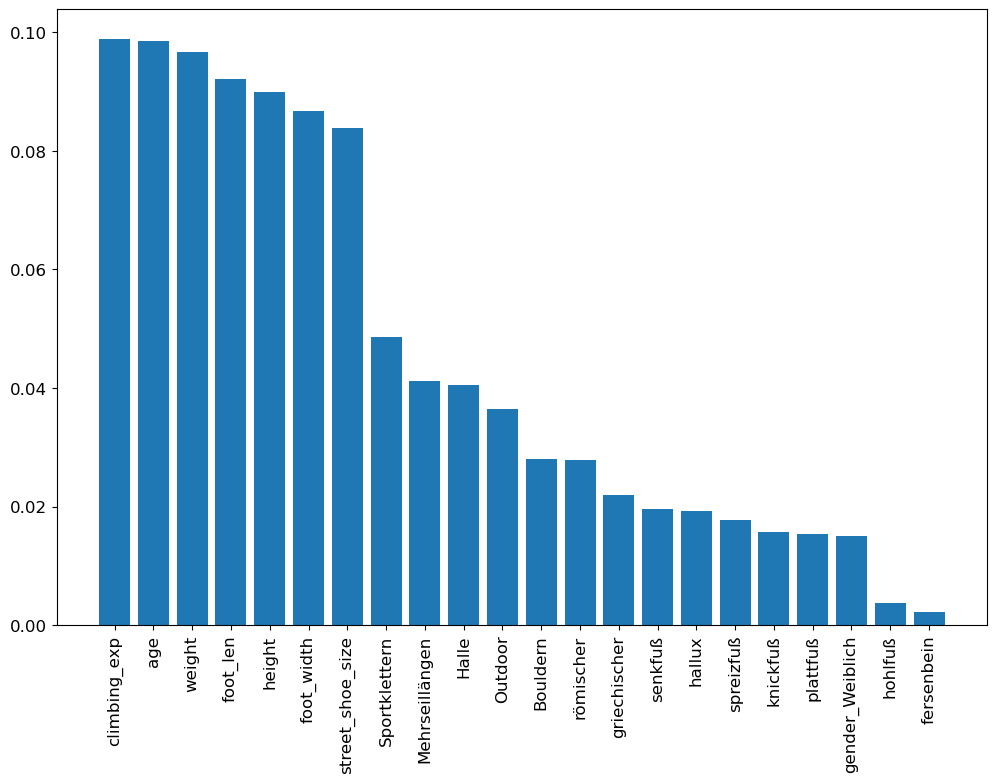

In [290]:
''' Random Forest Klassifikator: Wichtige Merkmale identifizieren
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

randomforest = RandomForestClassifier(random_state=0, n_jobs=-1)

model = randomforest.fit(X, y)

importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

names = [X.columns[i] for i in indices]

plt.figure(figsize=(12, 8))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [291]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

X = df_prep.values
y= pd.get_dummies(data=df_survey['shoe_model'],drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_train)

scaled_X.shape

(124, 22)

In [292]:
y_train.shape

(124, 77)

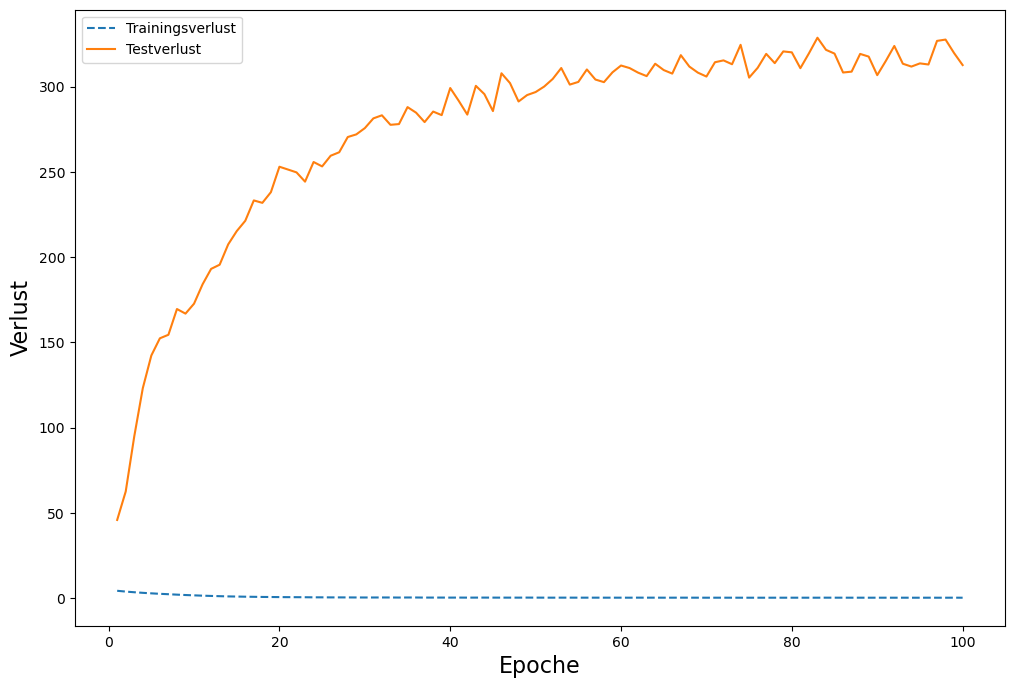

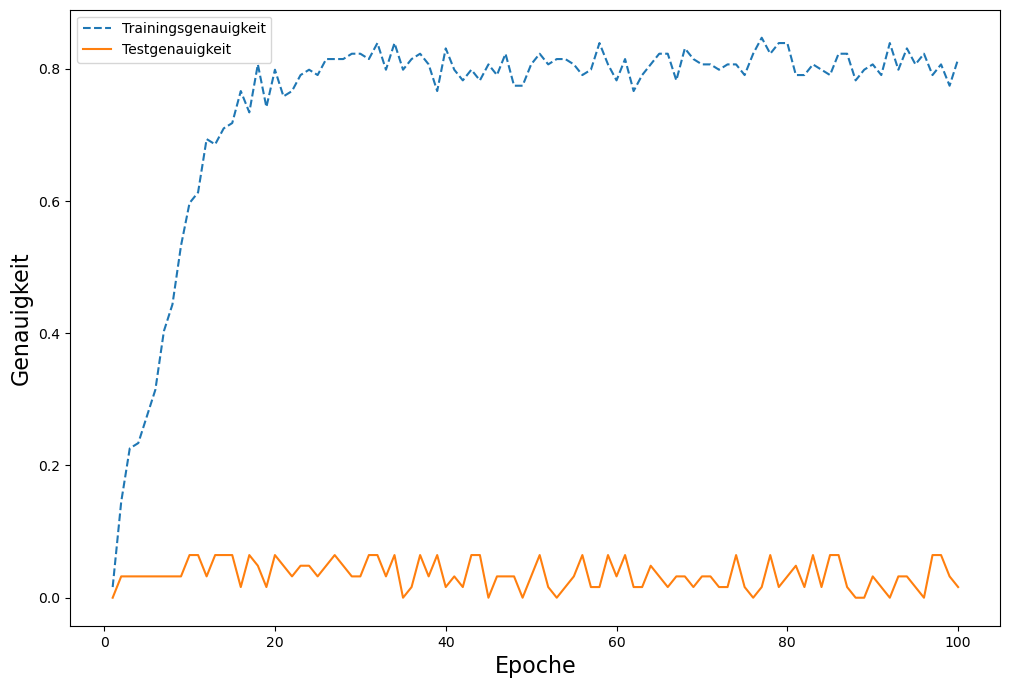

In [293]:
from tensorflow.keras import models
from tensorflow.keras import layers

network = models.Sequential()

network.add(layers.Dense(units=150, 
                         activation="relu",
                        input_shape=(22,)))

network.add(layers.Dense(units=150, activation="relu"))
network.add(layers.Dense(units=77, activation="softmax"))

network.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

history = network.fit(scaled_X, 
                      y_train,
                     epochs=100,
                     verbose=0,
                     batch_size=10,
                     validation_data=(X_test, y_test))


training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

epoc_count = range(1, len(training_loss) +1)

plt.figure(figsize=(12,8))
plt.plot(epoc_count, training_loss, "--")
plt.plot(epoc_count, test_loss)
plt.legend(["Trainingsverlust", "Testverlust"])
plt.xlabel("Epoche", fontsize=16)
plt.ylabel("Verlust", fontsize=16)
plt.show()

traning_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

plt.figure(figsize=(12,8))
plt.plot(epoc_count, traning_accuracy, "--")
plt.plot(epoc_count, test_accuracy)
plt.legend(["Trainingsgenauigkeit", "Testgenauigkeit"])
plt.xlabel("Epoche", fontsize=16)
plt.ylabel("Genauigkeit", fontsize=16)
plt.show()

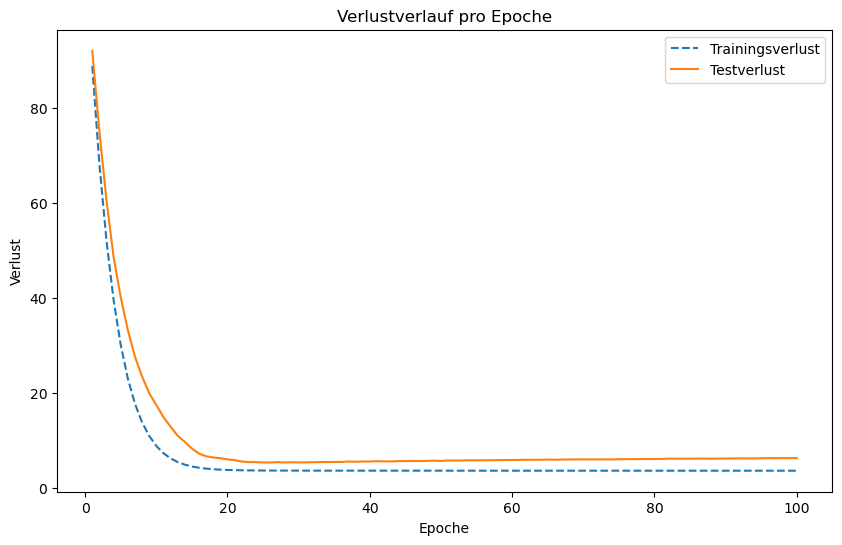

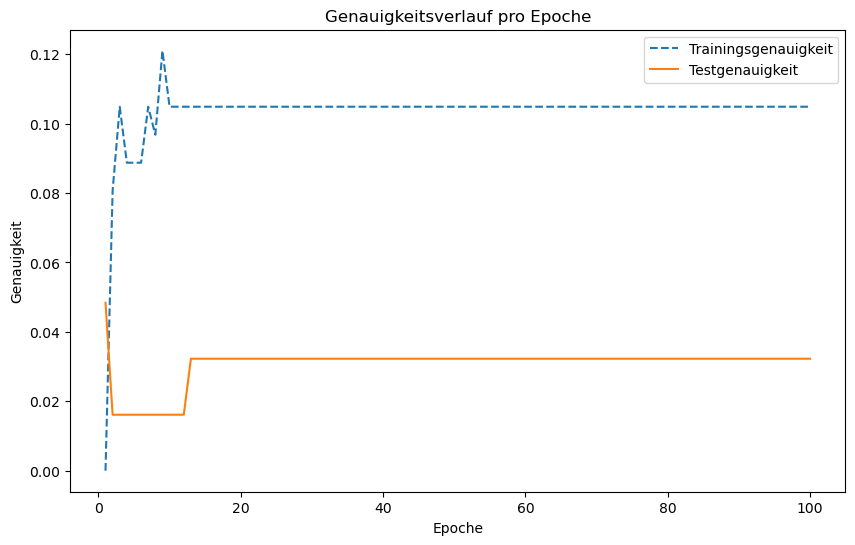

In [301]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

network = models.Sequential()

network.add(layers.Dense(units=150, 
                         activation="relu",
                         kernel_regularizer=regularizers.l2(0.5),
                        input_shape=(22,)))

network.add(layers.Dense(units=150, activation="relu",  kernel_regularizer=regularizers.l2(0.5)))
network.add(layers.Dense(units=77, activation="softmax"))

network.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

history = network.fit(scaled_X, 
                      y_train,
                     epochs=100,
                     verbose=0,
                     batch_size=10,
                     validation_data=(X_test, y_test))


training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

epoc_count = range(1, len(training_loss) +1)

plt.figure(figsize=(10,6))
plt.title("Verlustverlauf pro Epoche")
plt.plot(epoc_count, training_loss, "--")
plt.plot(epoc_count, test_loss)
plt.legend(["Trainingsverlust", "Testverlust"])
plt.xlabel("Epoche")
plt.ylabel("Verlust")
plt.show()

traning_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

plt.figure(figsize=(10,6))
plt.title("Genauigkeitsverlauf pro Epoche")
plt.plot(epoc_count, traning_accuracy, "--")
plt.plot(epoc_count, test_accuracy)
plt.legend(["Trainingsgenauigkeit", "Testgenauigkeit"])
plt.xlabel("Epoche")
plt.ylabel("Genauigkeit")
plt.show()

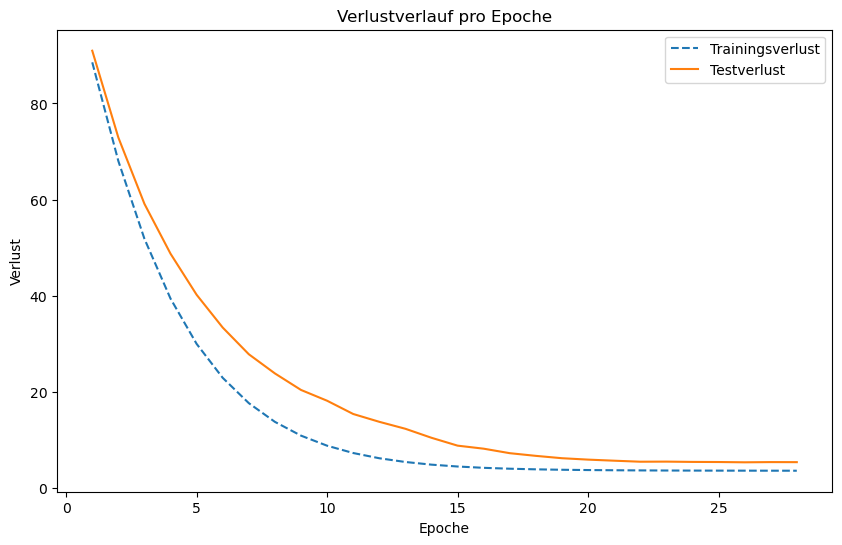

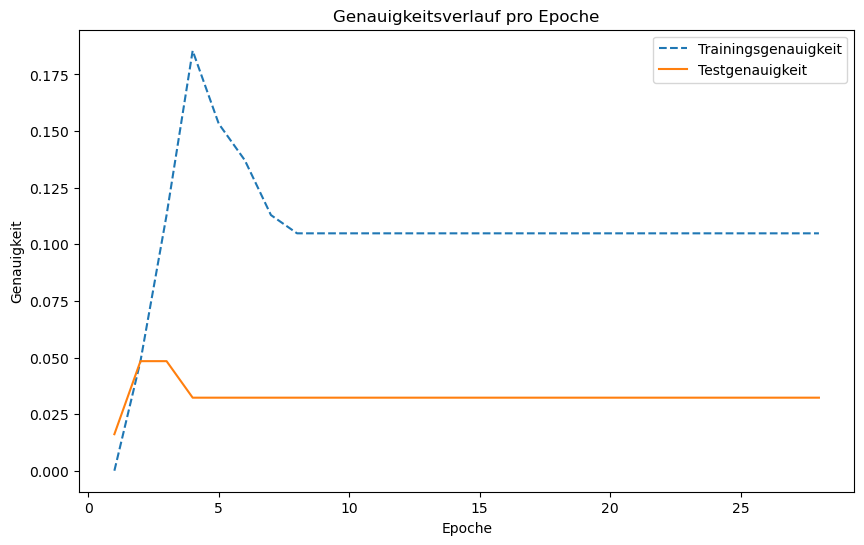

In [295]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

network = models.Sequential()

network.add(layers.Dense(units=150, 
                         activation="relu",
                         kernel_regularizer=regularizers.l2(0.5),
                        input_shape=(22,))) 

network.add(layers.Dense(units=150, activation="relu",  kernel_regularizer=regularizers.l2(0.5)))
network.add(layers.Dense(units=77, activation="softmax")) #Output

network.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

callbacks = [EarlyStopping(monitor="val_loss", patience=2),
            ModelCheckpoint(filepath="best_model.h5",
                           motitor="val_loss",
                           save_best_only=True)]

history = network.fit(scaled_X, 
                      y_train,
                     epochs=100,
                      callbacks=callbacks,
                     verbose=0,
                     batch_size=10,
                     validation_data=(X_test, y_test))


training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

epoc_count = range(1, len(training_loss) +1)

plt.figure(figsize=(10,6))
plt.title("Verlustverlauf pro Epoche")
plt.plot(epoc_count, training_loss, "--")
plt.plot(epoc_count, test_loss)
plt.legend(["Trainingsverlust", "Testverlust"])
plt.xlabel("Epoche")
plt.ylabel("Verlust")
plt.show()

traning_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

plt.figure(figsize=(10,6))
plt.title("Genauigkeitsverlauf pro Epoche")
plt.plot(epoc_count, traning_accuracy, "--")
plt.plot(epoc_count, test_accuracy)
plt.legend(["Trainingsgenauigkeit", "Testgenauigkeit"])
plt.xlabel("Epoche")
plt.ylabel("Genauigkeit")
plt.show()

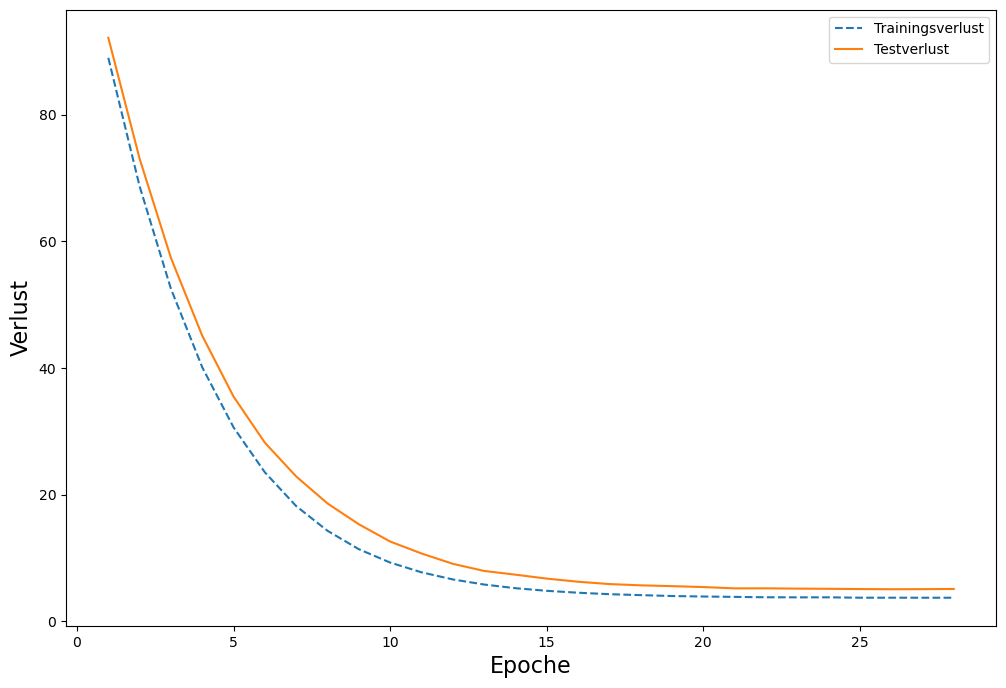

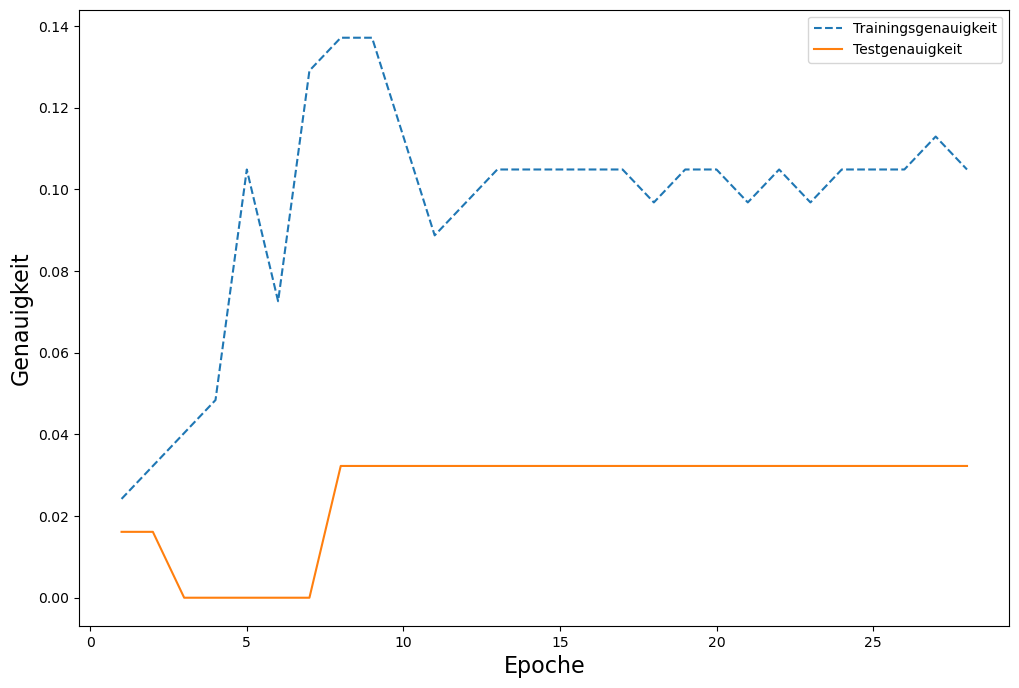

In [296]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

network = models.Sequential()

network.add(layers.Dropout(0.2, input_shape=(22,)))
network.add(layers.Dense(units=150, 
                         activation="relu",
                         kernel_regularizer=regularizers.l2(0.5),
                        input_shape=(22,)))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=150, activation="relu",  kernel_regularizer=regularizers.l2(0.5)))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(units=77, activation="softmax")) # Output

network.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=["accuracy"])

callbacks = [EarlyStopping(monitor="val_loss", patience=2),
            ModelCheckpoint(filepath="best_model.h5",
                           motitor="val_loss",
                           save_best_only=True)]

history = network.fit(scaled_X, 
                      y_train,
                     epochs=100,
                     callbacks=callbacks,
                     verbose=0,
                     batch_size=10,
                     validation_data=(X_test, y_test))


training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

epoc_count = range(1, len(training_loss) +1)

plt.figure(figsize=(12,8))
plt.plot(epoc_count, training_loss, "--")
plt.plot(epoc_count, test_loss)
plt.legend(["Trainingsverlust", "Testverlust"])
plt.xlabel("Epoche", fontsize=16)
plt.ylabel("Verlust", fontsize=16)
plt.show()

traning_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

plt.figure(figsize=(12,8))
plt.plot(epoc_count, traning_accuracy, "--")
plt.plot(epoc_count, test_accuracy)
plt.legend(["Trainingsgenauigkeit", "Testgenauigkeit"])
plt.xlabel("Epoche", fontsize=16)
plt.ylabel("Genauigkeit", fontsize=16)

plt.show()

In [297]:
sorted(history.history["accuracy"])[-1]

0.13709677755832672